##This notebook is used to demultiplex the sequencing run into the corresponding samples, according to their barcodes

In [248]:
# Imports all the necessary programs
# screed for making databases
# pandas, which is a library of Python data analysis functions
# Counter tool for convenient and rapid tallies
# matplotlib for plotting
# numpy for basic computing in Python
# mpltools are more tools for matplotlib
import screed
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from mpltools import style

In [249]:
# sets our style parameters to ggplot
style.use("ggplot")

In [250]:
# tells the notebook to show the output (graphics) from matplotlib inline (in the notebook)
%matplotlib inline

In [ ]:
# This step unzips our index read fastq file.
!pigz -k -d -p 2 ../../SeqData/20150624_I1_001.fastq.gz
# -k means keep the original, -d means decompress the input, -p means use this number of processors

###Creating our databases to compare index file with sequence file

In [4]:
# This creates the database which it will query
# The database will have the sequence name, description, quality, and sequence itself (if those data are in the original files)
# The output will be the same file with NAME_screed
screed.read_fastq_sequences("../../SeqData/20150624_I1_001.fastq")

<ScreedDB, '../../SeqData/20150624_I1_001.fastq_screed'>

In [42]:
# tells the notebook where our index reads are
ir1 = "../../SeqData/20150624_I1_001.fastq"

In [262]:
# Loads our index reads database created above
ir1db = screed.ScreedDB(ir1)

In [232]:
# locating the tab delimited file with the index reads and the sample IDS
# Note that 0,1,2,3,4 are just row numbers
# I need to make this file in excel
# This step is making that information into a data frame (using panda), called df_map
# Note that the first items are identified by a "0" (Python uses a 0-index)
# Also note that the first column was made up by the program - not present in the initial file.
df_map = pd.read_csv("../../SeqData/MapFile.txt", delimiter="\t", usecols=[0,1], names=["i1","SampleID"])
# uses Pandas to read our csv file of our sequence data.
# We only had one indexed read, so we 
# prints the head of the dataframe we made called df_map
df_map[1:4]

,i1,SampleID
1,1,TGTTATCGCACA
2,2,CTTACACCAAGT
3,3,AGTTCCCGAGTA


In [238]:
# map calls a function (lambda) for a sequence of items (zipped)
# lambda creates a function, into which x is input. 
# Here, we are getting whatever x was at 0, 1, and 2 (so the first three columns of our data), and adding the first two
# together (our indicies), and maintaining the second one (our sample IDs).
# "Zipping" links together three elements of the same length, effectively creating an array of vectors
# So, here, we have linked together the columns in our mapping dataframe, df_map.
# Basically, we link together the three columns, using zip, and then we concatenate the first two values
# at each place and keep the last one separate, using the lambda function we created here.
# This happens using the map function - the function called is defined by lambda, the sequence of items we look at 
# is defined by the zip function
# Dict is a data structure in Python, the "dictionary"
# A dictionary has unique keys that are linked to other data
# Here we are using our map output to make the dictionary. The map created two values - our combined indicies and ID.
# Thus, the map_d.keys at a given position will be the combined index primers,
# and the map_d returned when the map_d.keys at a given position is input, will be our sample ID.
map_d = dict(map(lambda x: (x[0], x[1]), zip(df_map.SampleID,df_map.i1,)))
print map_d.keys()[20], map_d[map_d.keys()[20]]

AAGGGAGGAGAC 93


In [241]:
map_d['TACTTCGCTCGC']

'67.2'

In [18]:
# We already created the database with our merged sequence files in merge_reads
# The output will be the same file with NAME_screed
# screed.read_fastq_sequences("../../SeqData/pear_merged-2015-07-03.assembled.fastq")

<ScreedDB, '../../SeqData/pear_merged-2015-06-30.assembled.fastq_screed'>

In [265]:
# Loads the screed database
db = screed.ScreedDB("../../SeqData/pear_merged-2015-07-03.assembled.fastq_screed")

### Beware: the script below will overwrite your fastq file - make sure it works before running it!

In [ ]:
# Sets a counting index and starts the number of unassigned reads at zero.
# Defines our output as our fastq file.
# Sets up a counter function, which is actually like a dictionary.
# Assigns our assembled sequence data
counter = 0
unassigned = 0
cnt = Counter()
fq = "../../SeqData/pear_merged-2015-07-03.assembled.crop.fastq"

# "w" means we are opening the file to "w"rite
with open(fq, "w") as out:
# for each record in our database (of sequence reads, est. above) that we go through iteratively...
  for rec in db.itervalues(): 
        # We get the name of this record, and then find that same name in our index db, and get the associated sequence
        index = ir1db[rec["name"]]["sequence"]
        # We take the index sequence found above (matching the sample's name), and find it in our map file
        # This should spit out the ID of the sample associated with these indicies, which we then join to
        # an underscore, and the current counter value (which number sequence is this?)
        try:
            new_name = map_d[index] + "_" + str(counter) #case sensitive
            # If we couldn't find the index name in our dictionary map file, we say it was unassigned, and tally it.
        except KeyError:
            unassigned += 1
            continue
            # Resetting to continue
        counter += 1
        # map_d[index_etc.lower] should give us the sample name we assigned to that index set.
        # We feed that into the counter - not quite sure what happens
        # We also increase [what?] by 1.
        cnt[map_d[index]] += 1 #case sensitive
        # We define s and q as the sequence and accuracy values (from our screed db) 
        s, q = rec["sequence"], rec["quality"]
        # The output written to the file we called fn will be all this..not quite sure what's going on.
        out.write("@%s orig_name=%s\n%s\n+\n%s\n"%(new_name,rec["name"],s,q))
        # Reports how many reads didn't match the mapping file. Note that we require an exact match here.
print "Unable to assign %s reads to samples"%unassigned
# The final output should be still a fastq file but now with the sample ID attached.
# For now it is called pear_merged-2014-03-25.assembled.demult.fastq

In [264]:
!head ../../SeqData/pear_merged-2015-07-03.assembled.fastq

@67.2_0 orig_name=M01056:152:000000000-AGL01:1:1101:15992:1344
TTGCCAGCCGCCGCGGTAAGACGTAGGGTGCAAGCGTTGTCCGGATTTATTGGGCATAAAGAGCTCGTAGGCGGCTTGTTGCGTCGACCGTGAAAACCTACCGCTTAACGGTGGGCTTGCGGTCGATACGGGCAGGCTAGAGTTCGGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCCGATACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACAGGATTAGATACCCTTGTAGTCCCACGATA
+
1>111111>>>AEE00E0011B/F/0//B/A111//EE/FDE?A/EEHIGIII=I/EIIH@I==GIIEIIIIIIIIIIIIII<CII<<I=I=IIIIIIIIIIIIIGIIIIIIIHIIIIIII9II:IIIIIGIIIG<IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIGGGGGGFGGFHGGGGHHHHHHHHHHGGFGCGGGGGGFFBBBFFBA>33
@74.2_1 orig_name=M01056:152:000000000-AGL01:1:1101:15812:1357
TTGCCAGCCGCCGCGGTAATACGAAGGGGGCTAGCGTTGTTCGGATTTACTGGGCGTAAAGCGCACGTAGGCGGATCGATCAGTCAGGGGTGAAATCCCAGGGCTCAACCCTGGAACTGCCTTTGATACTGTCGATCTGGAGTATGGAAGAGGTGAGTGGAATTCCGAGTGTAGAGGTGAAATTCGTAGATATTCGGAGGAACACCAGTGGCGAAGGCGGCTCACTGGTCCATTACTGACGCTGAGGTGCGAAAGCGTGGGGAGCAAACAGG

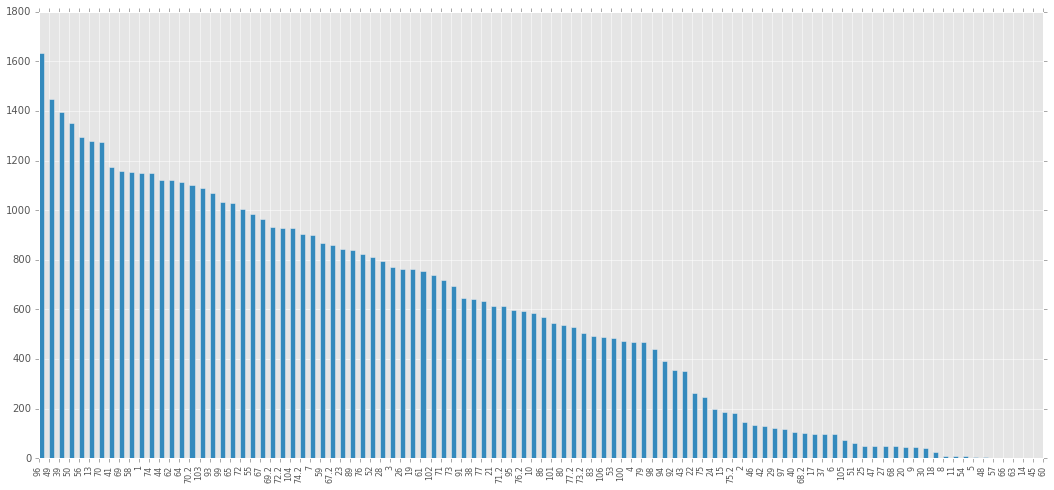

In [261]:
# Makes a plot of read counts organized by index
# Seems like it worked okay - lowest 12 reads <50,000 counts.
X = np.arange(len(cnt.keys()))
Y = [v for k, v in cnt.most_common()]
fig = plt.figure()
fig.set_size_inches((18,8))
ax = fig.add_subplot(111)
bars = ax.bar(X, Y, width=0.5)
xlims = ax.set_xlim((X.min(), X.max()))
xt = ax.set_xticks(X)

xtl = ax.set_xticklabels([k for k, v in cnt.most_common()], rotation=90, ha="center", size=8)

### What if I just try using the QIIME library separator?

In [58]:
!head -10000 ../../SeqData/20150624_I1_001.fastq > ../../SeqData/20150624_I1_001.crop.fastq

In [257]:
!head -1000000 ../../SeqData/pear_merged-2015-07-03.assembled.fastq > ../../SeqData/pear_merged-2015-07-03.assembled.crop.fastq

In [63]:
!head -10000 ../../SeqData/20150624_R1_001.fastq > ../../SeqData/20150624_R1_001.crop.fastq

In [62]:
!wc -l ../../SeqData/pear_merged-2015-07-03.assembled.fastq
# 33876136

 33057800 ../../SeqData/pear_merged-2015-07-03.assembled.fastq


In [31]:
!grep 'ACACGCGGTTTA' ../../SeqData/20150624_I1_001.fastq

In [69]:
!validate_mapping_file.py -m ../../SeqData/MapFile.txt

Errors and/or warnings detected in mapping file.  Please check the log and html file for details.


In [72]:
!split_libraries_fastq.py -i ../../SeqData/20150624_R1_001.crop.fastq \
--max_barcode_errors 0 \
-b ../../SeqData/20150624_I1_001.crop.fastq \
-o ../../SeqData/assembled.split.fastq -m ../../SeqData/MapFile.txt -q 1 --barcode_type 12 --rev_comp_mapping_barcodes

In [11]:
!head -16 ../../SeqData/test.demulti.fastq/seqs.fna

>A1_0 M01056:152:000000000-AGL01:1:1101:16161:1343 1:N:0:0 orig_bc=TTTTTCTTTTTT new_bc=TTTTTCTTTTTT bc_diffs=0
TCGTGCCAGCCGCCGCGGTAATACGTAGGGTGCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGCAGGCGGCTCATTAAGACAGGCGTGAAATCCCCGGGCTTAACCTGGGAACTGCGCTTGTGACTGGTGGGCTAGAGTGTGTCAGAGGGAGGTGGAATTCCACGTGTAGCAGTGAAATGCGTAGAGATGTGGAGGAACACCGATGGCGAAGGCAGCCTCCTGGGATAACACTGACGCTCATGCACGAAAGCGTGGGGAGCAAACAGGATTAGATACCCCAGTAGTCCACAGA
>B2_1 M01056:152:000000000-AGL01:1:1101:15992:1344 1:N:0:0 orig_bc=TACTTCGCTCGC new_bc=TACTTCGCTCGC bc_diffs=0
TTGCCAGCCGCCGCGGTAAGACGTAGGGTGCAAGCGTTGTCCGGATTTATTGGGCATAAAGAGCTCGTAGGCGGCTTGTTGCGTCGACCGTGAAAACCTACCGCTTAACGGTGGGCTTGCGGTCGATACGGGCAGGCTAGAGTTCGGTAGGGGAGACTGGAATTCCTGGTGTAGCGGTGAAATGCGCAGATATCAGGAGGAACACCGGTGGCGAAGGCGGGTCTCTGGGCCGATACTGACGCTGAGGAGCGAAAGCGTGGGGAGCGAACAGGATTAGATACCCTTGTAGTCCCACGATA
>C3_2 M01056:152:000000000-AGL01:1:1101:15906:1348 1:N:0:0 orig_bc=ACAAGACCAGAA new_bc=ACAAGACCAGAA bc_diffs=0
TCAGTGAGTCATCGAATCTTTGAACGCACCTTGCGCTCTTTGGTATTCCGAAGAGCATGCCTGTTTG

####It basically works, but it needs the full initial fastq file to match the full initial index reads file - so, running PEAR first doesn't work. That's why we tried using the homemade sequence ID matcher above.

## Since I haven't gotten the barcode sample IDs yet, I could process these data by extracting the unique barcodes, and then at least have those IDs... it's not the best, but I might see some grouping anyway. Can't go that far without the IDs though.

In [12]:
%load_ext mothurmagic

In [16]:
! usearch -fastq_filter ../../SeqData/20150624_I1_001.fastq \
-fastaout ../../SeqData/20150624_I1_001.fasta \
-fastq_ascii 64
# Turning the fastq index file into a fasta file.
# We're just doing this so we can run the unique.seqs command on it in mothur
# and then pull out the barcodes to group by.

usearch v8.0.1623_i86osx32, 4.0Gb RAM (17.2Gb total), 4 cores
(C) Copyright 2013-15 Robert C. Edgar, all rights reserved.
http://drive5.com/usearch

Licensed to: tlw59@cornell.edu

00:48 1.6Mb  100.0% Filtering, 100.0% passed
   8469034  FASTQ recs (8.5M)               
   8469034  Converted (8.5M, 100.0%)


In [21]:
%%mothur
unique.seqs(fasta=../../SeqData/20150624_I1_001.fasta)
# Running this on the index file to get the different barcodes.
# We can then look at the counts - there should be 99-100 dominant ones, then a bunch of errors.

mothur > unique.seqs(fasta=../../SeqData/20150624_I1_001.fasta)
8469034	2031859

Output File Names:
../../SeqData/20150624_I1_001.names
../../SeqData/20150624_I1_001.unique.fasta

[WARNING]: your sequence names contained ':'.  I changed them to '_' to avoid problems in your downstream analysis.

mothur > quit()


In [28]:
%%mothur
count.seqs(name=../../SeqData/20150624_I1_001.names)
# Generating the counts for the unique sequences

mothur > count.seqs(name=../../SeqData/20150624_I1_001.names)

Using 1 processors.
It took 22 secs to create a table for 8469034 sequences.


Total number of sequences: 8469034

Output File Names:
../../SeqData/20150624_I1_001.count_table


mothur > quit()


In [29]:
!head ../../SeqData/20150624_I1_001.count_table

Representative_Sequence	total	
M01056_152_000000000-AGL01_1_1101_16161_1343	133
M01056_152_000000000-AGL01_1_1101_15992_1344	28161
M01056_152_000000000-AGL01_1_1101_15906_1348	7429
M01056_152_000000000-AGL01_1_1101_15150_1349	4198
M01056_152_000000000-AGL01_1_1101_15295_1352	1
M01056_152_000000000-AGL01_1_1101_15812_1357	29081
M01056_152_000000000-AGL01_1_1101_16721_1367	7647
M01056_152_000000000-AGL01_1_1101_16742_1368	31913
M01056_152_000000000-AGL01_1_1101_14885_1371	15884


In [2]:
%load_ext rmagic

/opt/virt_env/lib/python2.7/site-packages/IPython/extensions/rmagic.py:693: UserWarning: The rmagic extension in IPython is deprecated in favour of rpy2.ipython. If available, that will be loaded instead.
http://rpy.sourceforge.net/
  warnings.warn("The rmagic extension in IPython is deprecated in favour of "


In [3]:
%%R
barcode.counts <- read.table("../../SeqData/20150624_I1_001.count_table", header=TRUE)

In [4]:
%%R
head(barcode.counts)

                       Representative_Sequence total
1 M01056_152_000000000-AGL01_1_1101_16161_1343   133
2 M01056_152_000000000-AGL01_1_1101_15992_1344 28161
3 M01056_152_000000000-AGL01_1_1101_15906_1348  7429
4 M01056_152_000000000-AGL01_1_1101_15150_1349  4198
5 M01056_152_000000000-AGL01_1_1101_15295_1352     1
6 M01056_152_000000000-AGL01_1_1101_15812_1357 29081


In [5]:
%%R
dim(barcode.counts)

[1] 2031859       2


In [6]:
%%R
barcode.counts.sorted <- barcode.counts[order(-barcode.counts$total),] 

In [7]:
%%R
head(barcode.counts.sorted)

                         Representative_Sequence  total
59  M01056_152_000000000-AGL01_1_1101_14198_1428 100608
65  M01056_152_000000000-AGL01_1_1101_15528_1431  62157
122 M01056_152_000000000-AGL01_1_1101_16755_1468  56844
116 M01056_152_000000000-AGL01_1_1101_14428_1464  47582
87  M01056_152_000000000-AGL01_1_1101_13967_1447  47081
154 M01056_152_000000000-AGL01_1_1101_15326_1487  44741


In [8]:
%%R
barcode.counts.sorted.mini<-barcode.counts.sorted[1:500,]

In [9]:
%%R
barcode.counts.sorted[1:200,]

                          Representative_Sequence  total
59   M01056_152_000000000-AGL01_1_1101_14198_1428 100608
65   M01056_152_000000000-AGL01_1_1101_15528_1431  62157
122  M01056_152_000000000-AGL01_1_1101_16755_1468  56844
116  M01056_152_000000000-AGL01_1_1101_14428_1464  47582
87   M01056_152_000000000-AGL01_1_1101_13967_1447  47081
154  M01056_152_000000000-AGL01_1_1101_15326_1487  44741
36   M01056_152_000000000-AGL01_1_1101_16732_1402  44732
189  M01056_152_000000000-AGL01_1_1101_15496_1513  44429
82   M01056_152_000000000-AGL01_1_1101_14514_1443  43703
39   M01056_152_000000000-AGL01_1_1101_17019_1407  43525
186  M01056_152_000000000-AGL01_1_1101_17888_1511  42980
297  M01056_152_000000000-AGL01_1_1101_13555_1576  42960
247  M01056_152_000000000-AGL01_1_1101_16866_1549  39397
494  M01056_152_000000000-AGL01_1_1101_18781_1708  39211
30   M01056_152_000000000-AGL01_1_1101_16766_1398  38901
235  M01056_152_000000000-AGL01_1_1101_15336_1542  38896
25   M01056_152_000000000-AGL01

In [9]:
%%R
#install.packages("ggplot2")
# Only need to install once
library(ggplot2)

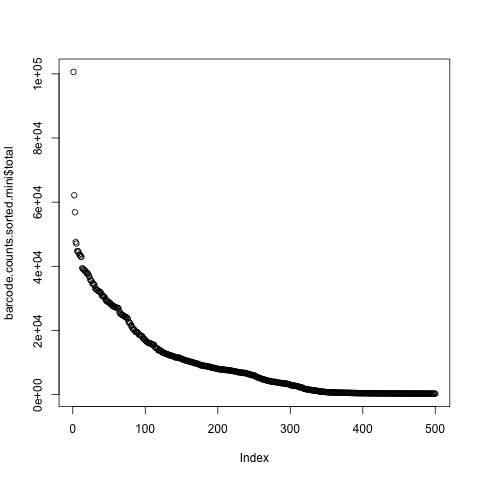

In [10]:
%%R
plot(barcode.counts.sorted.mini$total)

I was hoping there would be clear barcode sequences, but since they are somewhat uneven, it's not really possible to pick them out. Thus, we will have to wait to get the real things.
Maybe what we're seeing is an echo of the 1st 100, with their errors, and so on.

In [131]:
!grep 'ATGGTTGTTGGC' ../../SeqData/20150624_I1_001.fasta

ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC
ATGGTTGTTGGC

I tried searching for a barcode in the sequencing data as well, forward, backwards, and complemented each way. It only turned up in one sequence, and it seemed pretty clearly just a random part of the sequence - it was in the middle. However, I was able to find it flipped and reverse-complemented in the index file after all. Yay!